In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kkbox-churn-prediction-challenge/transactions_v2.csv.7z
/kaggle/input/kkbox-churn-prediction-challenge/sample_submission_v2.csv.7z
/kaggle/input/kkbox-churn-prediction-challenge/train_v2.csv.7z
/kaggle/input/kkbox-churn-prediction-challenge/user_logs.csv.7z
/kaggle/input/kkbox-churn-prediction-challenge/train.csv.7z
/kaggle/input/kkbox-churn-prediction-challenge/WSDMChurnLabeller.scala
/kaggle/input/kkbox-churn-prediction-challenge/members_v3.csv.7z
/kaggle/input/kkbox-churn-prediction-challenge/sample_submission_zero.csv.7z
/kaggle/input/kkbox-churn-prediction-challenge/transactions.csv.7z
/kaggle/input/kkbox-churn-prediction-challenge/user_logs_v2.csv.7z


In [3]:
!pip install py7zr


     |████████████████████████████████| 65 kB 311 kB/s 
     |████████████████████████████████| 13.7 MB 8.0 MB/s 


In [4]:
!python -m py7zr /kaggle/input/kkbox-churn-prediction-challenge/train.csv.7z
!py7zr x /kaggle/input/kkbox-churn-prediction-challenge/train.csv.7z

usage: py7zr [-h] [--version] {l,x,c,t,i} ...
py7zr: error: invalid choice: '/kaggle/input/kkbox-churn-prediction-challenge/train.csv.7z' (choose from 'l', 'x', 'c', 't', 'i')


In [5]:
df = pd.read_csv('train.csv')

In [6]:
df.shape

(992931, 2)

In [7]:
!python -m py7zr /kaggle/input/kkbox-churn-prediction-challenge/transactions.csv.7z

!py7zr x /kaggle/input/kkbox-churn-prediction-challenge/transactions.csv.7z


usage: py7zr [-h] [--version] {l,x,c,t,i} ...
py7zr: error: invalid choice: '/kaggle/input/kkbox-churn-prediction-challenge/transactions.csv.7z' (choose from 'l', 'x', 'c', 't', 'i')


In [8]:
df_trans = pd.read_csv("transactions.csv", parse_dates=['membership_expire_date','transaction_date'])

In [9]:
df_trans.shape

(21547746, 9)

#### We Have Roughly 2 Crores 15 Lakhs of User Transactions , Now Next Questions is Are all this transactions Unique?

In [10]:
pd.unique(df_trans['msno']).shape

(2363626,)

#### Out of 2 Crores 15 Lakhs Transcations only 23 Lakhs Unique User Id's are present , This can happen as user can do Multiple Transactions 

In [11]:
df_trans.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,2015-09-30,2015-11-01,0
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,2015-09-30,2015-10-31,0
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30,129,129,1,2015-09-30,2016-04-27,0
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30,149,149,1,2015-09-30,2015-11-28,0
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,2015-09-30,2015-11-21,0


#### What is Minimum Value of Transaction Date amongst all transactions ?


In [12]:
df_trans['transaction_date'].min()

Timestamp('2015-01-01 00:00:00')

#### What is Maximum Value of Transaction Date Amongst all transactions ?

In [13]:
df_trans['transaction_date'].max()

Timestamp('2017-02-28 00:00:00')

#### What is Minimum Value of Expiry Date ?

In [14]:
df_trans['membership_expire_date'].min()

Timestamp('1970-01-01 00:00:00')

### That's Pretty Much an Outlier !

In [15]:
df_trans["membership_expire_date"].max()

Timestamp('2017-03-31 00:00:00')

### Lets only Keep The User Activities with most recent Transactions and Not all Historical

In [16]:
df_trans = df_trans.sort_values('transaction_date').drop_duplicates('msno' , keep = 'last' )

In [17]:
df_trans.shape

(2363626, 9)

### We are now Getting 23 Lakhs Unique User activities consisting of Most Recent Transactions , Lets Join This Table with Train Dataset Consisting of Churn Information so that we can do some analysis

In [18]:
df = df.merge(df_trans , on = ['msno'] , how = 'left')

In [19]:
df.shape

(992931, 10)

In [20]:
df.head()

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,38,30,149,149,0,2017-01-07,2017-02-06,0
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,39,30,149,149,1,2017-02-24,2017-03-21,1
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,39,30,149,149,1,2017-01-12,2017-02-03,1
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,38,410,1788,1788,0,2016-01-06,2017-02-20,0
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,38,30,149,149,0,2017-01-28,2017-02-27,0


### Join Results Look Quite Good Lets check for Null Values

In [21]:
df.isna().sum()

msno                      0
is_churn                  0
payment_method_id         0
payment_plan_days         0
plan_list_price           0
actual_amount_paid        0
is_auto_renew             0
transaction_date          0
membership_expire_date    0
is_cancel                 0
dtype: int64

### Luckily , No Null Values Are Present Lets Move Forward With Some EDA

#### How Many Users Are There For Each Churn and Non Churn Classes Who Have Actively Cancelled Their Subscription

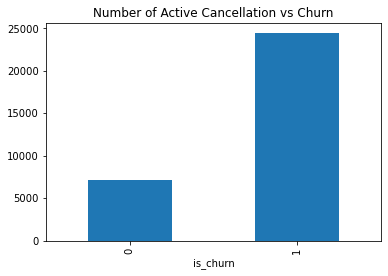

In [22]:
df.groupby("is_churn")['is_cancel'].sum().plot(kind = 'bar', title = "Number of Active Cancellation vs Churn")

### We can see Clearly for Non Churn Users , Active cancellation is very less roughly 7k and for Churned users the Number of Active Cancellation is very high roughly 25k

### How Many Users Auto-Renew their Subscription Based on Whether they are churn or non churn?

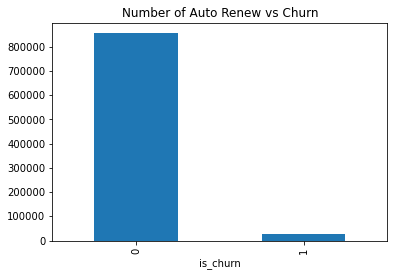

In [23]:
df.groupby("is_churn")['is_auto_renew'].sum().plot(kind = 'bar', title = "Number of Auto Renew vs Churn")

#### We can see that very few Churn Users Auto Renew Their Subscriptions , infact for Non Churn Users The Number of auto renew is significantly very large , lets look at actual numbers 

In [24]:
df.groupby("is_churn")['is_auto_renew'].sum()

is_churn
0    855320
1     27395
Name: is_auto_renew, dtype: int64

1. For churn users number of auto_renew is very less 27k approx
2. for non churn users number of auto_renew is very large approximately 850k

### Conclusions Till Now:
1. is_cancel can be very important categorical feature towards our task of churn classification as number of churn users having actively cancelled their subscriptions is very high.
2. is_auto_renew can be again very important categorical feature towards our task of churn classification as number of churn users , having Auto renew their subscriptions is very less

### Now , Lets Analyse How Much Amount of Money is spent by Churn and Non Churn Users , We need to check if there exists a trend like churn users spend less amount or Non Churn Users spend More Amount

In [25]:
## Separating non churned users and churn users data for easy analysis
df_non_churn = df[df['is_churn']==0]
df_churn = df[df['is_churn']==1]

In [26]:
df_non_churn['is_churn'].value_counts()

0    929460
Name: is_churn, dtype: int64

In [27]:
df_churn['is_churn'].value_counts()

1    63471
Name: is_churn, dtype: int64

# Actual Amount Spend By Churn and Non Churn Users analysis

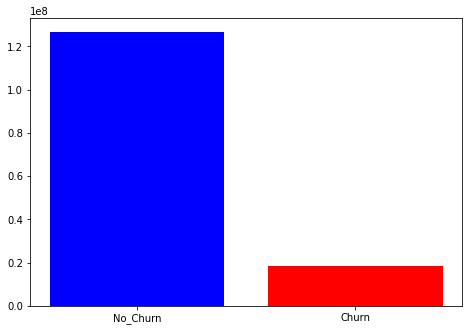

In [28]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels= ['No_Churn', 'Churn']
Total_Amount_Spend = [df_non_churn['actual_amount_paid'].sum(),df_churn['actual_amount_paid'].sum()]
ax.bar(labels,Total_Amount_Spend,color=['b','r'])
plt.show()

### We see that Non Churn Users Have Spend Much more on the platform then the churn users , Lets do basic statistics of actual amount spend by churn and non churn users

# Statistics of Actual Amount Paid By Non Churn Users

In [29]:
print("Mean Value of Actual Amount Paid By Non Churn Users is " , np.mean(df_non_churn["actual_amount_paid"]))
print("Median Value of Actual Amount Paid By Non Churn Users is " , np.median(df_non_churn["actual_amount_paid"]))
print("Max Value of Actual Amount Paid By Non Churn Users is " , np.max(df_non_churn["actual_amount_paid"]))
print("Min Value of Actual Amount Paid By Non Churn Users is " , np.min(df_non_churn["actual_amount_paid"]))
print("Standard Deviation Value of Actual Amount Paid By Non Churn Users is " , np.std(df_non_churn["actual_amount_paid"]))


Mean Value of Actual Amount Paid By Non Churn Users is  136.497726636972
Median Value of Actual Amount Paid By Non Churn Users is  149.0
Max Value of Actual Amount Paid By Non Churn Users is  2000
Min Value of Actual Amount Paid By Non Churn Users is  0
Standard Deviation Value of Actual Amount Paid By Non Churn Users is  100.73160899390813


### Lets Compute Histograms and Pdf for Non Churn Users

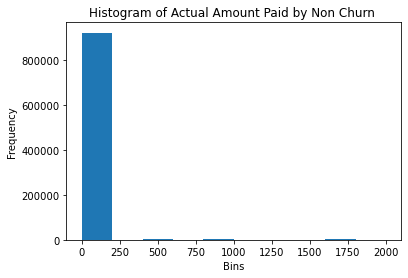

In [30]:
# https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
counts , bin_edges = np.histogram(df_non_churn['actual_amount_paid'],bins =10 , density = True) 
plt.hist(df_non_churn['actual_amount_paid'] , bins = 10)
plt.xlabel("Bins")
plt.ylabel("Frequency")
plt.title("Histogram of Actual Amount Paid by Non Churn ")
plt.show()

### Observations:
1. Very Large Number of Users Spend between 0-200 dollars(or currency)
2. There are very very few numbers of people who spend >250 dollars .
3. This can be thought as how we observe in most OTT platform today , Very Few Users buy expensive premium plans , Most users resort to using less expensive and affordable plans

[9.90850601e-01 3.44285929e-05 4.08839541e-03 6.99330794e-05
 2.06571558e-03 1.39866159e-05 9.36027371e-05 3.08781443e-04
 2.47240333e-03 2.15178706e-06]
[   0.  200.  400.  600.  800. 1000. 1200. 1400. 1600. 1800. 2000.]


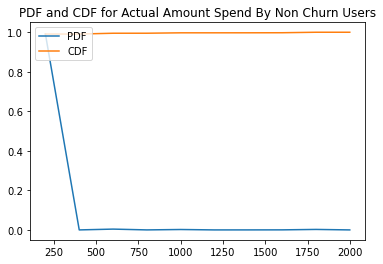

In [31]:
# refrence : https://www.youtube.com/watch?v=MEvYZiz-mK4&list=PLupD_xFct8mFDeCqoUAWZpUddeqmT28_L&index=5
pdf = counts/(sum(counts))
print(pdf);
print(bin_edges);
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:],pdf, label ="PDF");
plt.plot(bin_edges[1:], cdf , label = "CDF")
plt.legend(loc="upper left")
plt.title("PDF and CDF for Actual Amount Spend By Non Churn Users")
plt.show()

### Lets Compute Percentiles and Quantiles

In [32]:
print("25 % of Non Churn users Spends Amount  below ",np.percentile(df_non_churn["actual_amount_paid"],q=25)) # computing 25th Percentile -->1st Quantile
print("50 % of Non Churn users Spends Amount  below ",np.percentile(df_non_churn["actual_amount_paid"],q=50)) # computing 50th Percentile -->1st Quantile
print("75 % of Non Churn users Spends Amount  below ",np.percentile(df_non_churn["actual_amount_paid"],q=75)) # computing 75th Percentile -->1st Quantile
print("95 % of Non Churn users Spends Amount  below ",np.percentile(df_non_churn["actual_amount_paid"],q=95)) # computing 75th Percentile -->1st Quantile


25 % of Non Churn users Spends Amount  below  99.0
50 % of Non Churn users Spends Amount  below  149.0
75 % of Non Churn users Spends Amount  below  149.0
95 % of Non Churn users Spends Amount  below  180.0


### Interpretation of This percentiles and Quantiles
1. 25 % of customers spends less than or equal to 99 dollars on platform
2. 50 % of customers spends less than or equal to 149 dollars on platform
3. 75 % of customers spends less than or equal to 149 dollars on platform
3. 95 % of customers spends less than or equal to 180 dollars on platform


# Statistics of Actual Amount Paid by Churn Users

### Lets do statistics of Actual amount paid by churn users and compare it against what we get for non churn users

In [33]:
print("Mean Value of Actual Amount Paid By  Churn Users is " , np.mean(df_churn["actual_amount_paid"]))
print("Median Value of Actual Amount Paid By  Churn Users is " , np.median(df_churn["actual_amount_paid"]))
print("Max Value of Actual Amount Paid By  Churn Users is " , np.max(df_churn["actual_amount_paid"]))
print("Min Value of Actual Amount Paid By  Churn Users is " , np.min(df_churn["actual_amount_paid"]))
print("Standard Deviation Value of Actual Amount Paid By Churn Users is " , np.std(df_churn["actual_amount_paid"]))


Mean Value of Actual Amount Paid By  Churn Users is  289.81298545792566
Median Value of Actual Amount Paid By  Churn Users is  149.0
Max Value of Actual Amount Paid By  Churn Users is  2000
Min Value of Actual Amount Paid By  Churn Users is  0
Standard Deviation Value of Actual Amount Paid By Churn Users is  419.2568121721127


## Observations.
1. The Mean and Median Value of Churn Users , is Suprisingly greater than the mean and median value of Non Churn users.
2. The Minimum and Maximum Value of Actual Amount paid , remains the same for both churn and non churn users.
3. But if We Observe the Standard deviation , there is more spread in actual amount paid by churn users as compared to non churn
4. Also as number of churn users are very less as compared to non churn users , we are having this high values of mean and median for churn users

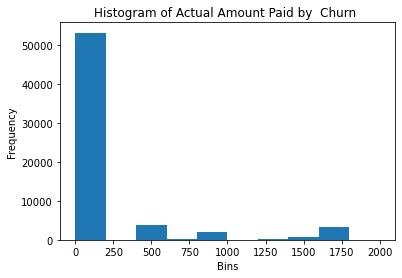

In [34]:
# https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
counts , bin_edges = np.histogram(df_churn['actual_amount_paid'],bins =10 , density = True) 
plt.hist(df_churn['actual_amount_paid'] , bins = 10)
plt.xlabel("Bins")
plt.ylabel("Frequency")
plt.title("Histogram of Actual Amount Paid by  Churn ")
plt.show()

1. We see again Large Number of people in 0-100 dollars range of actual amount spend.
2. But a Surprising thing here is for certain bins like 400-550(approx) , 800 to 980 , 1600 to 1750 the frequency of churn users is very high as compared to non churn users

[8.37736919e-01 7.87761340e-04 6.10672591e-02 2.01666903e-03
 3.09432654e-02 3.30859763e-04 4.26966646e-03 9.42162562e-03
 5.33314427e-02 9.45313608e-05]
[   0.  200.  400.  600.  800. 1000. 1200. 1400. 1600. 1800. 2000.]


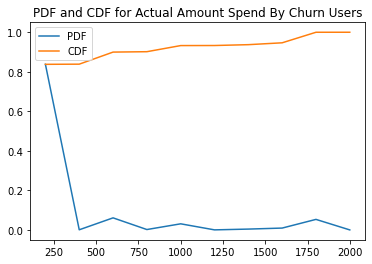

In [35]:
# refrence : https://www.youtube.com/watch?v=MEvYZiz-mK4&list=PLupD_xFct8mFDeCqoUAWZpUddeqmT28_L&index=5
pdf = counts/(sum(counts))
print(pdf);
print(bin_edges);
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:],pdf, label ="PDF");
plt.plot(bin_edges[1:], cdf , label = "CDF")
plt.legend(loc="upper left")
plt.title("PDF and CDF for Actual Amount Spend By Churn Users")
plt.show()

1. We are getting very different kind of pdf with peak value between 0 - 250 dollars
2. There are also considerable probabilities values at higher prices

In [36]:
print("25 % of  Churn users Spends Amount  below ",np.percentile(df_churn["actual_amount_paid"],q=25)) # computing 25th Percentile -->1st Quantile
print("50 % of  Churn users Spends Amount  below ",np.percentile(df_churn["actual_amount_paid"],q=50)) # computing 50th Percentile -->1st Quantile
print("75 % of  Churn users Spends Amount  below ",np.percentile(df_churn["actual_amount_paid"],q=75)) # computing 75th Percentile -->1st Quantile
print("95 % of  Churn users Spends Amount  below ",np.percentile(df_churn["actual_amount_paid"],q=95)) # computing 75th Percentile -->1st Quantile


25 % of  Churn users Spends Amount  below  149.0
50 % of  Churn users Spends Amount  below  149.0
75 % of  Churn users Spends Amount  below  180.0
95 % of  Churn users Spends Amount  below  1788.0


### Observations:
1. Even the 25th Percentile value for Churn Users is Higher than Non Churn Users 
2. Not only that even the 50th , 75th and 95th percentile for Churn Users are higher than Non Churn Users
3. We will see this and summarize it using boxplot

### Below is Box Plot for Churn and Non Churn Users for Actual Amount spend

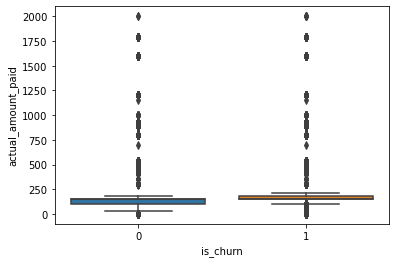

In [37]:
ax  = sns.boxplot(x="is_churn",y="actual_amount_paid", data = df)

1. From The Box Plot it can be Observed that the Box Plot of Churn Users is above the Box Plot of Non Churn Users.
2. Hence We are getting Higher Percentile Values for Actual Amount Paid for Churn Users , Than for Non Churn Users , Even though if we see Non Churn Users Have Spend More Money than Churn Users

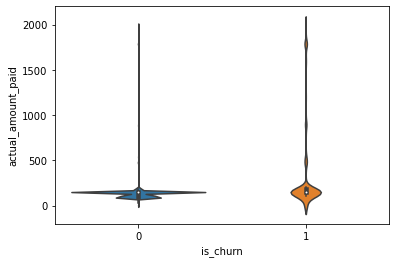

In [38]:
ax = sns.violinplot(x="is_churn",y="actual_amount_paid", data = df)

1. Violin Plot is like Summarizing PDF and Box Plot Together.
2. We see that the Probability Distribution for Actual Amount Spend is much more peaked for Non Churn Users , Whereas for Churn Users it is Much and More Smooth.

### Conclusion Till Now:
#### Actual Amount Paid can't be use in isolation for our task as it is very unstable feature , we can't arrive properly at churn values from this

In [39]:
df.head()

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,38,30,149,149,0,2017-01-07,2017-02-06,0
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,39,30,149,149,1,2017-02-24,2017-03-21,1
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,39,30,149,149,1,2017-01-12,2017-02-03,1
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,38,410,1788,1788,0,2016-01-06,2017-02-20,0
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,38,30,149,149,0,2017-01-28,2017-02-27,0


### Length of Membership Plan Variable Analysis

Feature 'payment_plan_days' Indicates length of Plan in Days Let us Analyze it to see whether it has some relation with churn users or not

In [40]:
print("Mean Value of Plan Length in Days for Non Churn Users is " , np.mean(df_non_churn["payment_plan_days"]))
print("Median Value of Plan Length in Days for Non Churn Users is " , np.median(df_non_churn["payment_plan_days"]))
print("Max Value of Plan Length in Days for Non Churn Users is " , np.max(df_non_churn["payment_plan_days"]))
print("Min Value of Plan Length in Days for Non Churn Users is " , np.min(df_non_churn["payment_plan_days"]))
print("Std Dev Value of Plan Length in Days for Non Churn Users is " , np.std(df_non_churn["payment_plan_days"]))


Mean Value of Plan Length in Days for Non Churn Users is  31.94509607729219
Median Value of Plan Length in Days for Non Churn Users is  30.0
Max Value of Plan Length in Days for Non Churn Users is  450
Min Value of Plan Length in Days for Non Churn Users is  1
Std Dev Value of Plan Length in Days for Non Churn Users is  23.00387998088473


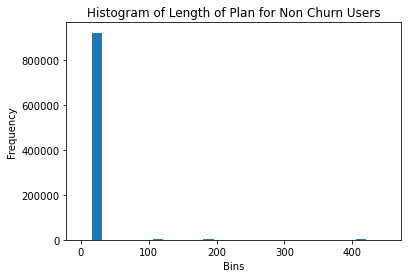

In [41]:
# https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
counts , bin_edges = np.histogram(df_non_churn['payment_plan_days'],bins =10 , density = True) 
plt.hist(df_non_churn['payment_plan_days'] , bins = 30)
plt.xlabel("Bins")
plt.ylabel("Frequency")
plt.title("Histogram of Length of Plan for Non Churn Users")
plt.show()

### Observations:
For Non Churn Users Length of Payment Plan is between 30-50 most of the times

[9.89960837e-01 9.27420222e-04 2.55417124e-03 1.26309900e-03
 2.08077809e-03 3.22768059e-04 0.00000000e+00 9.36027371e-05
 3.23843952e-04 2.47347922e-03]
[  1.   45.9  90.8 135.7 180.6 225.5 270.4 315.3 360.2 405.1 450. ]


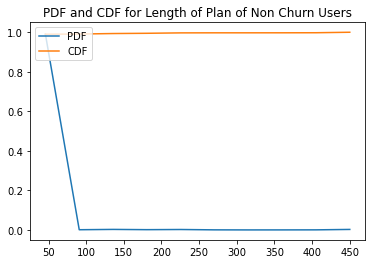

In [42]:
# refrence : https://www.youtube.com/watch?v=MEvYZiz-mK4&list=PLupD_xFct8mFDeCqoUAWZpUddeqmT28_L&index=5
pdf = counts/(sum(counts))
print(pdf);
print(bin_edges);
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:],pdf, label ="PDF");
plt.plot(bin_edges[1:], cdf , label = "CDF")
plt.legend(loc="upper left")
plt.title("PDF and CDF for Length of Plan of Non Churn Users")
plt.show()

### Length of Payment Plan for Churn Users

In [43]:
print("Mean Value of Plan Length in Days for  Churn Users is " , np.mean(df_churn["payment_plan_days"]))
print("Median Value of Plan Length in Days for  Churn Users is " , np.median(df_churn["payment_plan_days"]))
print("Max Value of Plan Length in Days for  Churn Users is " , np.max(df_churn["payment_plan_days"]))
print("Min Value of Plan Length in Days for  Churn Users is " , np.min(df_churn["payment_plan_days"]))
print("Std Dev Value of Plan Length in Days for  Churn Users is " , np.std(df_churn["payment_plan_days"]))


Mean Value of Plan Length in Days for  Churn Users is  67.55970443194529
Median Value of Plan Length in Days for  Churn Users is  30.0
Max Value of Plan Length in Days for  Churn Users is  450
Min Value of Plan Length in Days for  Churn Users is  0
Std Dev Value of Plan Length in Days for  Churn Users is  99.92229603035372


### Observations:
1. There can be some outliers present in Length of Payment plan field.
2. Because if you observe mean which is 67.55 days and Median is 30 days.
3. Here our mean is impacted by outliers , Impact is not that severe but till outliers present

## Violin Plot For Length of Plan

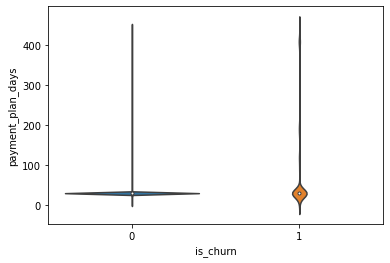

In [44]:
ax  = sns.violinplot(x="is_churn",y="payment_plan_days", data = df)

### Conculsions:
1. For Non Churn Users Distribution is more peaked , majority of payment plan is 30 days.
2. For Churn Users Distribution is spreaded but still majority are lieing in 30 days
3. Payment plan is not so useful feature because majority of KK Box Plan is of 30 days length , Hence user Subscribes/Re-Subscribes Every Month , so not so useful

### Correlation Heatmap

In [45]:
## before plotting correlation heatmap lets drop useless things from our dataframe

In [46]:
df.columns

Index(['msno', 'is_churn', 'payment_method_id', 'payment_plan_days',
       'plan_list_price', 'actual_amount_paid', 'is_auto_renew',
       'transaction_date', 'membership_expire_date', 'is_cancel'],
      dtype='object')

In [47]:
df.drop(columns=['msno','transaction_date','membership_expire_date'],inplace = True)

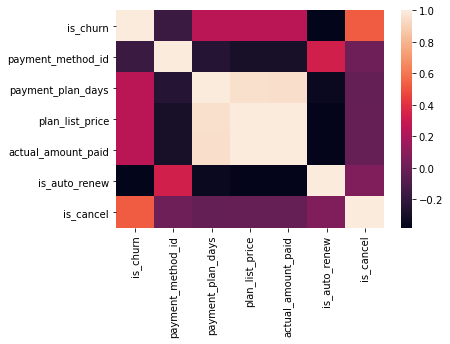

In [48]:
corr = df.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

### Observations:
1. Features payment_plan_days , plan_list_price , actual_amount_paid have same correlation of ~ 0.4 with is_churn
2. is_cancel have correlation of  ~0.7 with is_churn
3. On contrary 'is_auto_renew' is having correlation of 0.2 to 0.3 with is_cancel

### Final thoughts and Conclusions:
1. We can use features payment_plan_days , plan_list_price , actual_amount_paid and is_cancel as features to our machine learning model.
2. Here We have did analysis taking care of most recent transactions.
3. We need to do more data analysis of is_churn variable and see what information and useful features can we extract from following tables 'user_logs.csv' and 'members.csv'
4. Doing more analysis will help us build more features and improve our insight about domain